# Prepoznavanje spola imena pomoću neuronskih mreža
### Ivan Židov - Računalno jezikoslovlje

In [28]:
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Flatten, Input
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers.convolutional import Convolution1D, MaxPooling1D
import pandas as pd
import numpy as np
import re
import os
import keras

In [29]:
#Parametri
maxlen = 15 #najduža duljina riječi, tj. svaka riječ se dopuni s END do duljine 15
labels = 2 #broj klasa, u našem slučaju 2 pošto je samo muško i žensko

## Popis muških i ženskih slavenskih imena parsiran s https://www.behindthename.com/names/usage/slavic
Pošto ima imena s različitim slovima, ograničili smo na hrvatsku abecedu i xywq

In [30]:
myNames=[]
from unidecode import unidecode
chars = set('abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽxywqXYWQ\n')

with open('slavicnames.txt', 'r',encoding='utf-8') as f:
    #if all((c in chars) for c in (line.strip().lower()):
    myNames = myNames + [re.split(",",line.strip()) for line in f]
    #myNames = myNames + [(line.strip().lower(),'musko') if all((c in chars) for c in line) else None for line in f]

myNames=[(a,b) if all((c in chars) for c in a) else None for a,b in myNames]
myNames = [x for x in myNames if x is not None]

In [34]:
vocab = set(' '.join([str(i[0]) for i in myNames]))
vocab.add('END')
vocab = sorted(vocab)
len_vocab = len(vocab)
print(len(myNames))
myNames[:4]

2399


[('abdulah', 'm'), ('aca', 'm'), ('aco', 'm'), ('ada', 'f')]

In [35]:
print(sorted(vocab))
print("Broj slova",len_vocab)

[' ', 'END', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ć', 'č', 'đ', 'š', 'ž']
Broj slova 32


Indeksirajmo svako slovo kao index

In [36]:
char_index = dict((c, i) for i, c in enumerate(vocab))
print(char_index)

{' ': 0, 'END': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'ć': 27, 'č': 28, 'đ': 29, 'š': 30, 'ž': 31}


In [37]:
# Funkcija koja će nam brojati koliko ima muških a koliko ženskih imena u skupu
def muski_zenski(y):
    mc = 0
    zc = 0

    for i in y:
        if i[0]==1:
            mc=mc+1

        else:
            zc=zc+1
    return mc,zc

In [38]:
# Funkcija koja pravi listu duljine broja znakova i na i-tom mjestu je 1 a na svim ostalim 0
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return(tmp)

In [39]:
# Funkciija koja od liste riječi i spola radi vektor 
# gdje je svako slovo zamijenjeno vektorom koji ima 1 na indexu tog slova i ostatak dopuni s END i vektor za spol
def vectorize(parovi):
    X = []
    y = []
    for par in parovi:
        tmp = [set_flag(char_index[j]) for j in str(par[0])]
        for k in range(0,maxlen - len(str(par[0]))):
            tmp.append(set_flag(char_index["END"]))
        X.append(tmp)
        if par[1]=='m':
            y.append([1,0])
        elif par[1]=="f":
            y.append([0,1])
        elif (par[1]==("m & f") or par[1]==("f & m")): #ovo stavljamo jer u popisu ima nekih uni-sex imena
            y.append([0,1])
            X.append(tmp)
            y.append([1,0])      
        else:
            print("Greska")
            print(par[1])
    return(X,y)

Promiješamo listu imena

In [40]:
np.random.shuffle(myNames)
print(myNames[:4])
print(myNames[-4:])

[('nik', 'm'), ('angjelko', 'm'), ('jan', 'm'), ('milogost', 'm')]
[('sofija', 'f'), ('sofia', 'f'), ('onisim', 'm'), ('petruška', 'f')]


Razdvojimo imena na skupove za treniranje, validaciju i na test te ih vektoriziramo

In [41]:
train_X,train_y = vectorize(myNames[:2000])
val_X,val_y = vectorize(myNames[2000:2200])
test_X,test_y = vectorize(myNames[2200:2399])

In [42]:
print(np.array(test_y).shape)
print("U trening skupu imamo %d muških imena i %d ženskih imena" % muski_zenski(train_y))

(201, 2)
U trening skupu imamo 1125 muških imena i 895 ženskih imena


## Napravit ćemo 2 modela te ih usporediti

In [43]:
#Prvi model koji je sastavljen od LSTM-ova
print('Radim model1...')
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(maxlen,len_vocab)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64,activation="elu"))
model.add(Dropout(0.5))
#model.add(Dense(16,activation="elu"))
#model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Radim model1...


In [44]:
#Drugi model koji je sastavljen od konvolucijskih jednodimenzionalnih slojeva
print('Radim model2...')
nb_filter = 256
inputs = Input(shape=(maxlen,len_vocab), name='input')

conv = Convolution1D(nb_filter=nb_filter, filter_length=5,
                     border_mode='same', activation='relu',
                     input_shape=(maxlen, len_vocab))(inputs)
conv = MaxPooling1D(pool_length=3)(conv)

conv1 = Convolution1D(nb_filter=nb_filter, filter_length=3,
                      border_mode='same', activation='relu')(conv)
conv1 = MaxPooling1D(pool_length=3)(conv1)

conv5 = Flatten()(conv1)

z = Dropout(0.5)(Dense(64, activation='relu')(conv5))
z = Dropout(0.5)(Dense(16, activation='relu')(z))

pred = Dense(2, activation='softmax', name='output')(z)

model2 = Model(input=inputs, output=pred)

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

Radim model2...


C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(15, 32), filters=256, kernel_size=5, padding="same")`
  
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  if __name__ == '__main__':
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=256, kernel_size=3, padding="same")`
  if sys.path[0] == '':
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  del sys.path[0]
C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


## Treniramo oba modela i s callbackovima najbolje modele spremamo u "model1.h5" i "model2.h5"

In [45]:
callbacks1 = [ModelCheckpoint("model1.h5",monitor="val_loss",save_best_only=True)]
callbacks2 = [ModelCheckpoint("model2.h5",monitor="val_loss",save_best_only=True)]

batch_size=1000
history1 = model.fit(train_X, train_y,batch_size=batch_size,nb_epoch=75,validation_data=(val_X, val_y),callbacks=callbacks1)
history2 = model2.fit(train_X, train_y,batch_size=batch_size,nb_epoch=55,validation_data=(val_X, val_y),callbacks=callbacks2)

C:\Users\Ivan\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2020 samples, validate on 201 samples
Epoch 1/75
2020/2020 [==============================] - 3s 1ms/step - loss: 0.6917 - acc: 0.5178 - val_loss: 0.6982 - val_acc: 0.4726
Epoch 2/75
2020/2020 [==============================] - 0s 136us/step - loss: 0.6827 - acc: 0.5569 - val_loss: 0.7033 - val_acc: 0.4726
Epoch 3/75
2020/2020 [==============================] - 0s 161us/step - loss: 0.6781 - acc: 0.5569 - val_loss: 0.6912 - val_acc: 0.4726
Epoch 4/75
2020/2020 [==============================] - 0s 159us/step - loss: 0.6694 - acc: 0.5649 - val_loss: 0.6671 - val_acc: 0.6368
Epoch 5/75
2020/2020 [==============================] - 0s 158us/step - loss: 0.6596 - acc: 0.6911 - val_loss: 0.6381 - val_acc: 0.7512
Epoch 6/75
2020/2020 [==============================] - 0s 155us/step - loss: 0.6317 - acc: 0.7228 - val_loss: 0.6266 - val_acc: 0.6219
Epoch 7/75
2020/2020 [==============================] - 0s 154us/step - loss: 0.5977 - acc: 0.6955 - val_loss: 0.6413 - val_acc: 0.6269
Epo

2020/2020 [==============================] - 0s 134us/step - loss: 0.2517 - acc: 0.9050 - val_loss: 0.2409 - val_acc: 0.9254
Epoch 61/75
2020/2020 [==============================] - 0s 134us/step - loss: 0.2420 - acc: 0.9104 - val_loss: 0.3014 - val_acc: 0.8955
Epoch 62/75
2020/2020 [==============================] - 0s 134us/step - loss: 0.2436 - acc: 0.9089 - val_loss: 0.2508 - val_acc: 0.9303
Epoch 63/75
2020/2020 [==============================] - 0s 153us/step - loss: 0.2882 - acc: 0.8936 - val_loss: 0.2123 - val_acc: 0.9453
Epoch 64/75
2020/2020 [==============================] - 0s 141us/step - loss: 0.2133 - acc: 0.9257 - val_loss: 0.2533 - val_acc: 0.9204
Epoch 65/75
2020/2020 [==============================] - 0s 141us/step - loss: 0.2299 - acc: 0.9054 - val_loss: 0.2244 - val_acc: 0.9502
Epoch 66/75
2020/2020 [==============================] - 0s 148us/step - loss: 0.2075 - acc: 0.9297 - val_loss: 0.2106 - val_acc: 0.9552
Epoch 67/75
2020/2020 [==============================

C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 2020 samples, validate on 201 samples
Epoch 1/55
2020/2020 [==============================] - 2s 865us/step - loss: 0.7248 - acc: 0.4921 - val_loss: 0.7174 - val_acc: 0.4726
Epoch 2/55
2020/2020 [==============================] - 0s 74us/step - loss: 0.6923 - acc: 0.5391 - val_loss: 0.7066 - val_acc: 0.4726
Epoch 3/55
2020/2020 [==============================] - 0s 76us/step - loss: 0.6756 - acc: 0.5599 - val_loss: 0.6908 - val_acc: 0.4726
Epoch 4/55
2020/2020 [==============================] - 0s 76us/step - loss: 0.6754 - acc: 0.5594 - val_loss: 0.6654 - val_acc: 0.4925
Epoch 5/55
2020/2020 [==============================] - 0s 64us/step - loss: 0.6514 - acc: 0.6040 - val_loss: 0.6728 - val_acc: 0.4726
Epoch 6/55
2020/2020 [==============================] - 0s 77us/step - loss: 0.6357 - acc: 0.6322 - val_loss: 0.6351 - val_acc: 0.7313
Epoch 7/55
2020/2020 [==============================] - 0s 64us/step - loss: 0.6325 - acc: 0.6426 - val_loss: 0.6488 - val_acc: 0.4975
Epoch 8

Učitamo ta dva spremljena modela i usporedimo njihove rezultate na testnim skupovima

In [46]:
model11 = keras.models.load_model('model1.h5')
model22 = keras.models.load_model('model2.h5')
score, acc = model11.evaluate(test_X, test_y)
print('Test score model1:', score)
print('Test accuracy model1:', acc)
score, acc = model22.evaluate(test_X, test_y)
print('Test score model2:', score)
print('Test accuracy model2:', acc)

201/201 [==============================] - 0s 2ms/step
Test score model1: 0.16385385970497013
Test accuracy model1: 0.9402985074626866
201/201 [==============================] - 0s 2ms/step
Test score model2: 0.106937885525363
Test accuracy model2: 0.9651741293532339


In [47]:
# Funkcija koja vraća matricu konfuzije
def perf_measure(y_actual, y_pred):
    TZ = 0
    FZ = 0
    TM = 0
    FM = 0

    for i in range(len(y_pred)): 
        if y_actual[i][1]==np.round(y_pred[i][1])==1:
           TZ += 1
        if np.round(y_pred[i][1])==1 and y_actual[i][0]==1:
           FZ += 1
        if y_actual[i][0]==np.round(y_pred[i][0])==1:
           TM += 1
        if np.round(y_pred[i][0])==1 and y_actual[i][1]==1:
           FM += 1

    return(TZ, FZ, TM, FM)

In [48]:
print("Tablica konfuzije za model1:")
print("TŽ - Dobro predviđen ženski spol")
print("FŽ - Krivo predviđen ženski spol")
print("TM - Dobro predviđen muški spol")
print("FM - Krivo predviđen muški spol")

df = (pd.DataFrame(data={"Train":perf_measure(train_y,model11.predict(train_X)),"Val":perf_measure(val_y,model11.predict(val_X)),"Test":perf_measure(test_y,model11.predict(test_X))},index=["TŽ","FŽ","TM","FM"]))
print(df)
print()
print("Tablica konfuzije za model1:")
print("TŽ - Dobro predviđen ženski spol")
print("FŽ - Krivo predviđen ženski spol")
print("TM - Dobro predviđen muški spol")
print("FM - Krivo predviđen muški spol")
df = (pd.DataFrame(data={"Train":perf_measure(train_y,model22.predict(train_X)),"Val":perf_measure(val_y,model22.predict(val_X)),"Test":perf_measure(test_y,model22.predict(test_X))},index=["TŽ","FŽ","TM","FM"]))
print(df)

Tablica konfuzije za model1:
TŽ - Dobro predviđen ženski spol
FŽ - Krivo predviđen ženski spol
TM - Dobro predviđen muški spol
FM - Krivo predviđen muški spol
    Test  Train  Val
TŽ    85    862  102
FŽ     7     95    5
TM    98    968   85
FM     1     18    3

Tablica konfuzije za model1:
TŽ - Dobro predviđen ženski spol
FŽ - Krivo predviđen ženski spol
TM - Dobro predviđen muški spol
FM - Krivo predviđen muški spol
    Test  Train  Val
TŽ    87    876  102
FŽ     5     73    4
TM   107   1052   91
FM     2     19    4


Predviđanja za neka proizvoljna imena

In [49]:
name=["ivan","dolores","saša","ana","mitar","duje","tomislav","domagoj","lucija","hrvoje","josipa","hrvoje","mario","martina","nikola","luka","ines"]
X = []
for ime in name:
    tmp = [set_flag(char_index[j]) for j in str(ime)]
    for k in range(0,maxlen - len(str(ime))):
        tmp.append(set_flag(char_index["END"]))
    X.append(tmp)
pred1=model11.predict(np.asarray(X))
pred2=model22.predict(np.asarray(X))

In [50]:
np.set_printoptions(suppress=True)
tab = []
for i in range(len(name)):
    tab.append([name[i],pred1[i],np.argmax(pred1,axis=1)[i],pred2[i],np.argmax(pred2,axis=1)[i]])
pd.DataFrame(tab,columns=["Riječ","Model1","Model1 Predict","Model2","Model2 Predict"])

Riječ                      Model1  Model1 Predict  \
0       ivan     [0.51390165, 0.2751448]               0   
1    dolores    [0.9752514, 0.013415457]               0   
2       saša     [0.09311918, 0.7911372]               1   
3        ana     [0.03441085, 0.9264235]               1   
4      mitar    [0.68369323, 0.13607548]               0   
5       duje     [0.3888695, 0.36696056]               0   
6   tomislav     [0.940165, 0.025165264]               0   
7    domagoj  [0.99325377, 0.0017671644]               0   
8     lucija    [0.04273544, 0.89315176]               1   
9     hrvoje    [0.9703231, 0.019047353]               0   
10    josipa      [0.0821815, 0.7973042]               1   
11    hrvoje    [0.9703231, 0.019047353]               0   
12     mario    [0.9345947, 0.025540814]               0   
13   martina    [0.06709891, 0.84781927]               1   
14    nikola        [0.064105, 0.839066]               1   
15      luka    [0.06725263, 0.83841956]               1   
16      ines    [0.61031616, 0.23021345]               0   

                       Model2  Model2 Predict  
0      [0.953216, 0.04678393]               0  
1   [0.97021264, 0.029787352]               0  
2      [0.1151751, 0.8848249]               1  
3   [0.042924523, 0.95707554]               1  
4    [0.9634508, 0.036549237]               0  
5    [0.83470196, 0.16529797]               0  
6    [0.9884228, 0.011577182]               0  
7     [0.9948698, 0.00513013]               0  
8     [0.03199343, 0.9680065]               1  
9   [0.9863804, 0.0136196315]               0  
10   [0.062316142, 0.9376839]               1  
11  [0.9863804, 0.0136196315]               0  
12   [0.9915953, 0.008404652]               0  
13  [0.013287572, 0.98671246]               1  
14    [0.3752203, 0.62477964]               1  
15  [0.056717675, 0.94328237]               1  
16   [0.8838672, 0.116132766]               0

Graf o tome kako su se metrike kretale tijekom vremena za modele
Primjetimo da nakon ~40 epoha je model2 počeo overfittat

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


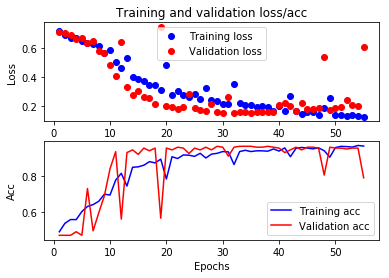

In [51]:
print(history1.history.keys())
loss = history1.history['loss']
val_loss = history1.history['val_loss']
acc = history1.history["acc"]
val_acc = history1.history["val_acc"]
epochs = range(1, len(loss) + 1)
plt.subplot(2,1,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss/acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()
print(history2.history.keys())
loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history["acc"]
val_acc = history2.history["val_acc"]
epochs = range(1, len(loss) + 1)
plt.subplot(2,1,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss/acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [52]:
def wrongones(model,X,y):
    pred = model.predict(X)
    indices = [i for i,v in enumerate(pred) if (np.round(pred[i][0])!=y[i][0])]
    subset_of_wrongly_predicted = [X[i] for i in indices ]
    krivi=[]
    for rijec in (subset_of_wrongly_predicted):
        rij = []
        for slovo in rijec:
            #rij.append(np.nonzero(slovo)[0][0])
            rij.append(list(char_index.keys())[list(char_index.values()).index(np.nonzero(slovo)[0][0])])
        a = ("".join(rij))
        krivi.append((re.split("END",a)[0]))
    return krivi

Ispis krivo određenih riječi za model1

In [53]:
(wrongones(model11,test_X,test_y))

['shura',
 'vlasi',
 'stane',
 'tadeaš',
 'viliam',
 'nikolai',
 'ignac',
 'miodrag',
 'spartak',
 'ninel',
 'grga',
 'pankrati',
 'atanas',
 'sava',
 'peta']

Ispis krivo određenih riječi za model2

In [54]:
wrongones(model22,val_X,val_y)

['peđa', 'nikol', 'petia', 'nebojša', 'beatrycze', 'karmen', 'foka', 'mare']

# Zaključak

Dobili smo preciznosti oko 95% na imena slavenskog porijetla. Ako bismo željeli staviti ovu funkcionalnost u funkciju, preporučio bih da se stavi "look-up table" za riječi krivo klasificiane, a za ostale riječi da se koristi klasifikator

In [69]:
hrv=[]
chars = set('abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽ\n')

with open('hrvatska_muska.txt', 'r',encoding='utf-8') as f:
    #if all((c in chars) for c in (line.strip().lower()):
    hrv = hrv + [(line.strip().lower(),'m') if all((c in chars) for c in line) else None for line in f]
with open('hrvatska_zenska.txt', 'r',encoding='utf-8') as f:
    hrv = hrv + [(line.strip().lower(),'f') if all((c in chars) for c in line) else None for line in f]
hrv = [x for x in hrv if x is not None]
print("U konačnici imamo",len(hrv),"imena")
print(hrv[:4])
print(hrv[-4:])
np.random.shuffle(hrv)

U konačnici imamo 947 imena
[('luka', 'm'), ('david', 'm'), ('jakov', 'm'), ('marko', 'm')]
[('zdeslava', 'f'), ('davorijanka', 'f'), ('blaženija', 'f'), ('jugosava', 'f')]


In [70]:
HRV,a = vectorize(hrv)

In [71]:
krivi=[]
for rijec in (HRV):
    rij = []
    for slovo in rijec:
            #rij.append(np.nonzero(slovo)[0][0])
        rij.append(list(char_index.keys())[list(char_index.values()).index(np.nonzero(slovo)[0][0])])
    a = ("".join(rij))
    krivi.append((re.split("END",a)[0]))
rijtest= krivi

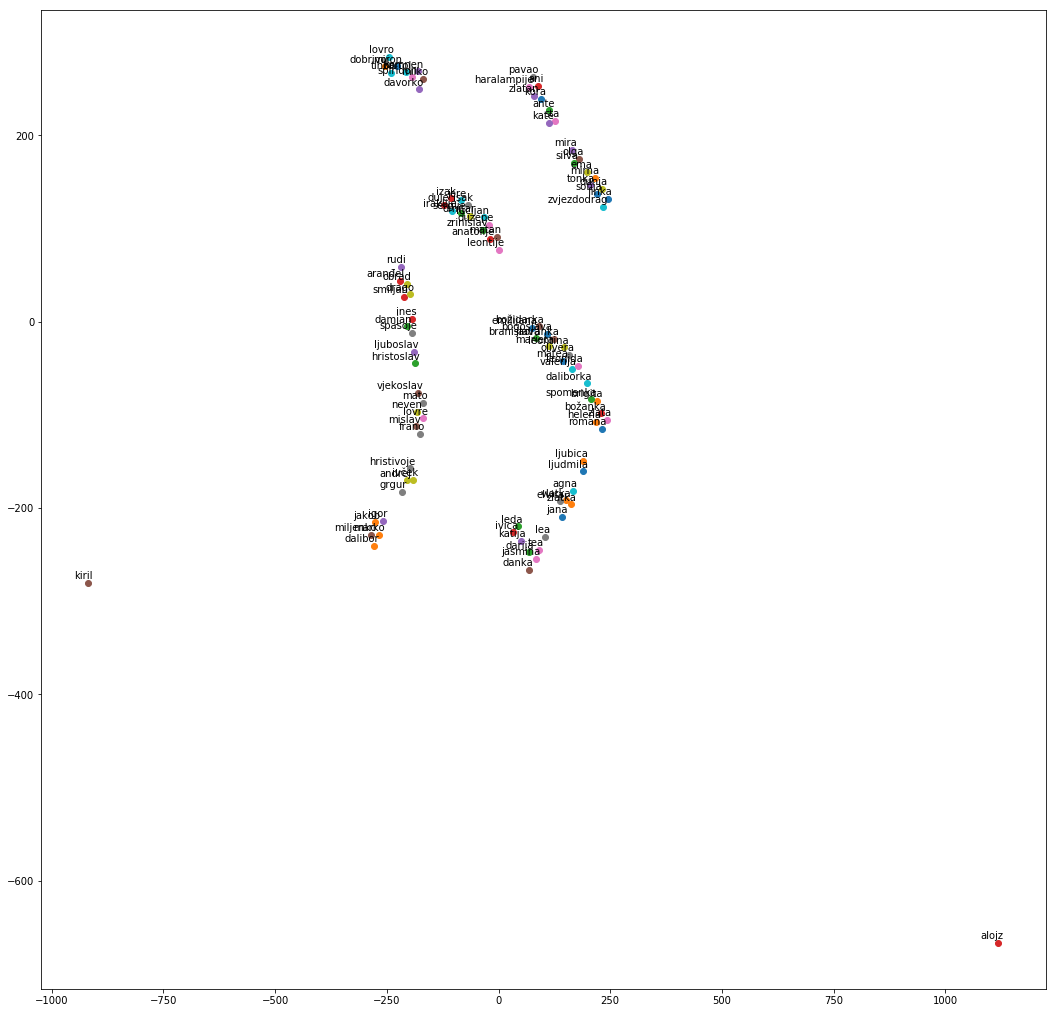

In [73]:
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)


# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=5.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(model.predict(HRV[:100]))

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, rijtest[:100])